In [7]:
%matplotlib inline  

import os
import pandas as pd 
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import codecs

# Analysis of Maxim Magazine's Hot 100
## *or: The "Last Fuckable Day" According to 16-Year-Old Bros, 2000-2016*
In Amy Schumer's brutally satirical sketch "[Last Fuckable Day](https://www.youtube.com/watch?v=XPpsI8mWKmg)", "In every actress's life, the media decides when you finally reach the point where you're not believably fuckable anymore," Particularly in Hollywood, it's a [real thing](http://www.laweekly.com/news/how-hollywood-keeps-out-the-stories-of-women-and-girls-6277451)

When I think about that emphemeral quality, let's call it "hotness" instead, it makes me think of Maxim Magazine. When I was a teenager, some of my friends had copies of the recently-launched Maxim Magazine, a north american version of what are called in England "lad magazines". Issues mixed saucy "how to be a man" advice articles and product reviews with teasing photoshoots of famous actresses, musicians and models, making them as sexy as possible without showing nipples or private parts. Needless to say, the internet made this magazine less relevant.

I vaguely remembered that they had readers vote on the top 100 hottest women every year, just to make the whole thing a bit more gross. But if we assume that media executives are often trying to sell things to 16-year-old, conventional, hetero, North American boys - and may themselves be of that mentality - then the Hot 100 lists should give insight into this specific concept of "hot".

I downloaded all 17 Hot 100 lists from the Maxim.com website (I had to get 2016's list from an online forum, but confirmed it was real), and did some data cleanup to compile them. There were a few data quality issues, ranging from outright missing items (empty `<li></li>` tags), to lists that only had 99 items, to women's names that had been stripped of unicode characters, such as ì, making them harder to look up, or were inconsistent across years (e.g. Beyoncé vs. Beyoncé Knowles). The lack of shits given when these lists were uploaded to the website can be judged from the fact that every year's list from 2000 to 2014 uses the same paragraph of text: 
> You voted, we counted, and the rest is super sexy history. From mind-bogglingly seductive supermodels to Hollywood,s most awe-inspiring actresses (with a bevy of beauties in between), the women of [the year] make up a roster so undeniably breathtaking you may get light-headed just reading it.

So neither the names nor the rankings can be expected to be totally accurate, but good enough for a fun project, and good enough to see broad trends.

In [4]:
# Read in the lists
listdir = 'lists/'
hot100_files  = os.listdir(listdir)

data = pd.DataFrame()
for h_file in hot100_files:
    if '.txt' not in h_file:
        continue
    year = int(h_file.split('.')[0])
    if year == 2016:
        with codecs.open(listdir + h_file,'r',encoding='utf-8') as f:
            names = []
            mranks = []
            waiting_for_rank = False
            for line in f:
                result = re.match('(.*) Maxim Rank - (\d+)', line)
                if result:
                    name, mrank = result.groups()
                    names.append(name.strip())
                    mranks.append(int(mrank))
            df = pd.DataFrame({'name':names,'mrank':mranks})
    else:
        df = pd.read_csv(listdir+ h_file, header=None, names=['name'], encoding='utf-8')
        df.loc[:,'name'] = df.loc[:,'name'].apply(lambda x: x.strip())
        df.loc[:,'mrank'] = df.index+1
    df.loc[:,'year'] = year
    

    data = data.append(df, ignore_index=True)

First I looked at the data in general and properties of the number of appearances.

Number of entries: 1691
Number of women: 748
Proportion appeared more than once: 0.44
Proportion appeared more than five times: 0.08
Number appeared more than five times: 58
Most appearances: Jessica Alba (17)


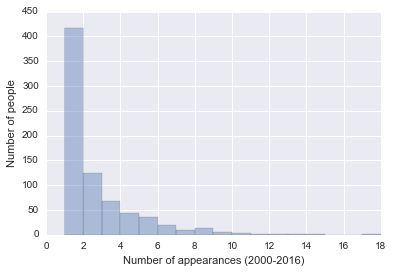

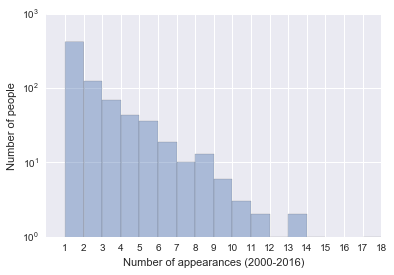

In [47]:
print "Number of entries: %d" % len(data)
print "Number of women: %d" % len(np.unique(data.name))

# Distribution of number of appearances
by_name = data.groupby(by='name')
num_years = by_name['year'].count()
plt.figure()
sns.distplot(num_years, bins = range(1,19), kde=False)
plt.xlabel('Number of appearances (2000-2016)')
plt.ylabel('Number of people')
plt.figure()
sns.distplot(num_years, bins = range(1,19), kde=False)
plt.gca().set_yscale('log')
plt.xlabel('Number of appearances (2000-2016)')
plt.ylabel('Number of people')
plt.xlabel('Number of appearances (2000-2016)')
plt.ylabel('Number of people')

plt.xticks(range(1,19))
print "Proportion appeared more than once: %.2f" % (float(np.sum(num_years > 1))/len(num_years))
print "Proportion appeared more than five times: %.2f" % (float(np.sum(num_years > 5))/len(num_years))
print "Number appeared more than five times: %d" % np.sum(num_years > 5)
print "Most appearances: %s (%d)" % (num_years[num_years == np.max(num_years)].index[0], np.max(num_years))

Although most people only appeared a few times on the charts, 58 people appeared more than 5 times, with Jessica Alba impressively appearing in all 17 lists, from ages 19 to 35. 

To continue with these questions, I needed accurate birthdate data, so I decided to hit Wikipedia. There is a real problem with making sure I got the right person: for example, I initially thought that Maxim had once put a 15 year old on the list, but it turned out to be the result of "Brittany Lee" being automatically disambiguated to [Brittany Lee Hensel](https://en.wikipedia.org/wiki/Abby_and_Brittany_Hensel), one of a pair of conjoined twins born in 1990. Therefore to reduce the chances of these false hits I had to disable wikipedia's disambiguation ability, despite the fact that it might help to find certain people from the Maxim-provided names (in particular, people with unicode characters in their names). I also discarded cases where multiple pages matched a person's name.

I discovered that once I selected the right wikipedia page, the birthdate could be reliably read for most people from the html on the sidebar. Since retrieving wikipedia pages is costly, about 1.2 seconds for each one, I also grabbed some more info on each person from their wikipedia entry for later analyses.

In [36]:
#%%
# Collect all the ages (and extra data) for women who have them listed in their 
# wikipedia pages (and for whom there are not more than 1 wikipedia hits)
import time
from dateutil.parser import parse
start = time.time()

gay_keywords = ['Lesbian','Bisexual','LGBT people','LGBT actresses']
trans_keywords = ['Transgender']
all_names = np.unique(data.name)
person_info = pd.DataFrame()
for name in all_names[:10]:
    try:
        page = wikipedia.page(name,auto_suggest=False,redirect=False)
    except wikipedia.DisambiguationError:
        print name + "\tToo many wikipedia hits" 
        continue
    except wikipedia.PageError:
        print name + "\tNo wikipedia hits" 
        continue
    except wikipedia.RedirectError:
        print name + "\tRedirect error"
        continue

    page_source = page.html()
    results = re.search('<span class=\"bday\">([^<]*)</span>', page_source)
    if not results:
        print name+ "\tNo birthdate"
        continue
    birthdate = results.groups()[0]
    print name + "\t" + birthdate
    person_info.loc[name,'birthdate' ] = birthdate

    # Extract alma mater
    alma_result = re.findall('Alma&#160;mater</th><td>\n(.*)</tr>', page_source,re.MULTILINE)    
    if alma_result:
        person_info.loc[name,'college_listed'] = 1
    else:
        person_info.loc[name,'college_listed'] = 0

    # Extract birthplace
    birthplace_result = re.search('<span class=\"birthplace\">(.*)</span>',page_source)
    if birthplace_result:
        if any(a in birthplace_result.groups()[0] for a in ['U.S.','United States','US','California','New York']):
            person_info.loc[name,'us_born'] = 1
        else:
            person_info.loc[name,'us_born'] = 0

    # Look for evidence she is lesbian or bi in their categories
    if any(any(keyword in category for keyword in gay_keywords) for category in page.categories):
        person_info.loc[name,'lesbian_or_bi'] = 1
    else:
        person_info.loc[name,'lesbian_or_bi'] = 0
        
    # Look for evidence she is transgender
    if any(any((keyword in category) and (not 'activist' in category) for keyword in trans_keywords) for category in page.categories):
        person_info.loc[name,'trans'] = 1
    else:
        person_info.loc[name,'trans'] = 0
        


A.J. Cook	Redirect error
Aaliyah	1979-01-16
Abbey Lee	Redirect error
Abbie Cornish	1982-08-07
Abby Elliot	Redirect error
Adriana Lima	1981-06-12
Adrianne Curry	1982-08-06
Adrianne Palicki	1983-05-06
Aisha Tyler	1970-09-18
Aki	Too many wikipedia hits


Since this takes a while to run, I just gave an example of the first 10 checked, and will now retrieve the rest.

In [70]:
person_info = pd.read_csv('maxim_person_info.csv',index_col=0,encoding='utf-8')
print '%d out of %d with unambiguous birthdates (%.1f%%)' % (len(person_info), len(all_names), 100* float(len(person_info))/len(all_names))

593 out of 748 with unambiguous birthdates (79.3%)


I lost quite a few, but there's still plenty left, and little reason to think any group was systematically excluded (except possibly people with special unicode characters in their name, which is a real concern for names of non-English origin). The next step is to parse the years, and then compute the age at the time of each list, by merging it with the overall lists.

In [71]:
#%%
# Parse the date and extract the year
for name,bd in person_info.iterrows():
    the_date = parse(bd.values[0]) # General purpose date string interpretation
    person_info.loc[name,'dt'] = the_date
    person_info.loc[name,'birth_year'] =the_date.year

with_ages = data.merge(person_info, how='right', left_on='name', right_index=True)

Then I can compute the age at the time of appearance on the list, and look at the basic distribution of ages.

count    1444.000000
mean       27.748615
std         5.117588
min        17.000000
25%        24.000000
50%        27.000000
75%        31.000000
max        49.000000
Name: age_at_time, dtype: float64
99% of hot 100 entries were this age or younger: 41.6


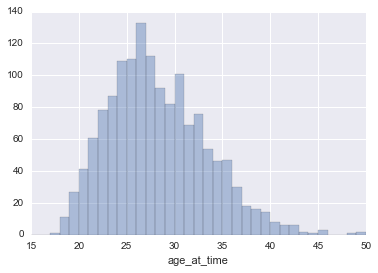

In [86]:
with_ages.loc[:,'age_at_time'] = with_ages.year - with_ages.birth_year              
sns.distplot(with_ages.age_at_time,kde=False,bins=range(10,51))
plt.xlim([15,50])
print with_ages.age_at_time.describe()
print "99%% of hot 100 entries were this age or younger: %.1f" % np.percentile(with_ages.age_at_time,99)

So with 99% of hot 100 entries under the age of 42, that's a reasonable "last day" for our douchey Maxim readers. But, there are exceptions:

In [87]:
with_ages.loc[with_ages.age_at_time > 41,['name','year','age_at_time']]

,name,year,age_at_time
1473,Gabrielle Union,2014,42.0
1230,Jennifer Lopez,2012,43.0
1429,Jennifer Lopez,2014,45.0
450,Gina Gershon,2004,42.0
670,Teri Hatcher,2006,42.0
988,Michelle Obama,2009,45.0
992,Marisa Tomei,2009,45.0
1262,Stephen Colbert,2012,48.0
1316,Heather Graham,2013,43.0
1347,Kamala Harris,2013,49.0


And we can look at age extremes:

In [111]:
oldest = with_ages.loc[with_ages.age_at_time==np.max(with_ages.age_at_time),:]
print "The oldest were %s and %s (age %d)" % (oldest.name.iloc[0],oldest.name.iloc[1], oldest.age_at_time.iloc[0])
youngest = with_ages.loc[with_ages.age_at_time==np.min(with_ages.age_at_time),:]
print "The youngest was %s (age %d)" % (youngest.name.values[0], youngest.age_at_time)

The oldest were Kamala Harris and Hoda Kotb (age 49)
The youngest was Mandy Moore (age 17)


And, for fun, birth year extremes:

In [122]:
earliest = with_ages.loc[with_ages.birth_year==np.min(with_ages.birth_year),:]
print "The one with the earliest birth year was %s (%d)" % (earliest.name.values[0], earliest.birth_year)
latest = with_ages.loc[with_ages.birth_year==np.max(with_ages.birth_year),:]
print "The one with the latest birth years were %s and %s (%d)" % (latest.name.iloc[0],latest.name.iloc[1], latest.birth_year.iloc[0])

The one with the earliest birth year was Gina Gershon (1962)
The one with the latest birth years were Hailey Baldwin and Bella Hadid (1996)


1996! That makes me feel old. 

In September 2014, [editor Kate Lanphear was hired to make over Maxim](http://nypost.com/2015/10/22/maxim-editor-ousted-after-failed-luxury-magazine-relaunch/) into less of a bro magazine, and more of a style and luxury magazine (I guess like GQ). Among her initiatives was to hire actual feminist Roxanne Gay to write [an introduction to the 2015 Hot 100](http://www.maxim.com/women/2015-hot-100) (inspiring a [Roose V](https://en.wikipedia.org/wiki/Roosh_V) forum member to write a post with the title "RIP Maxim Magazine -- Maxim latest victim of feminist takeover.") and to focus the interviews and essays that accompanied it on the achievements of the women (under new headings like The Ones to Watch), with photo spreads that were less objectifying.

Kate Lanphear was fired just over a year later. So that got me interested in whether we can see a blip in 2015 in the level of grossness (downward), and in general how the Hot 100 picks have changed over time. The section that would be comparable to other years would be the Reader's Picks section, but I have no doubt that editors have a lot of control over what goes on the list, considering it's an internet survey. Also perhaps it could change based on the change in the readership that they were trying for (keeping in mind that apparently the overall readership dropped like a rock under these new editorial directions).

The box plots of the ages show the distributions, including outliers such as Hoda Kotb:

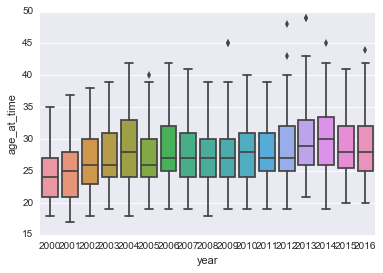

In [127]:
# Was there a different distribution of ages in different years?
plt.figure()
sns.boxplot(x='year',y='age_at_time',data=with_ages)

But changes to the median age are easier to see if we focus only on them:

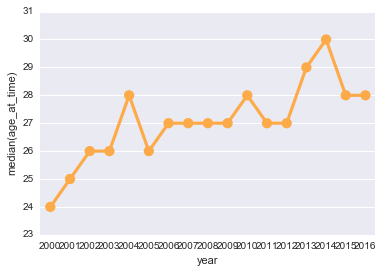

In [124]:
sns.pointplot(x='year',y='age_at_time',data=with_ages, ci=0, color=sns.xkcd_rgb["light orange"],estimator=np.median)

There appears to be a notable increase in median age over the last 17 years, from about 24 to about 28, with much of the increase occurring in the first 5 years of the Hot 100. Interestingly, 2014 is the oldest median year, whereas 2015 represents something of a return to form. 

We can look at individual cases more clearly by making a swarm plot of just the top 10 for each year. In this plot, each individual is a separate dot, and each year is represented by a different colour.

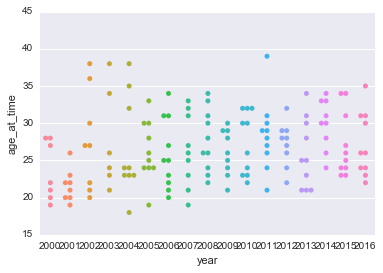

In [126]:
# Was there a different distribution of ages in different years?
plt.figure()
sns.swarmplot(x='year',y='age_at_time',data=with_ages.loc[(with_ages.mrank<=10),:])

The oldest outlier on this plot is Cameron Diaz, 39 years old in 2011 - the year Bad Teacher was released. Clearly she didn't appear in the top 10 in the years before or after. So that's a hint that the rankings are highly unstable, and probably based more on specific roles and specific advertising campaigns than any enduring characteristics of the people. (and that's without considering effects of tinkering by Maxim's editors on behalf of their advertisers)

Could the women of 2015 have differed in other ways? I looked at education level, using as a rough proxy whether an Alma Mater was listed in the Wikipedia biographical sidebar for that person (note that this would also include performing arts school - another analysis could look for the names of top academic schools)

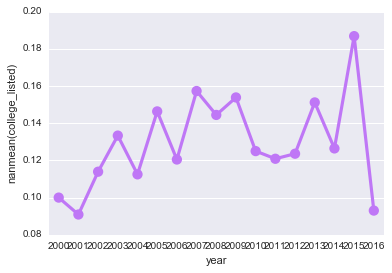

In [128]:
# Proportion with an alma mater listed
plt.figure()
sns.pointplot(x='year',y='college_listed',data=with_ages, ci = 0, color=sns.xkcd_rgb["light purple"], estimator=np.nanmean)

Here we do see a bit of a spike at 2015 - which is then immediately reversed for 2016, with less than 10% of the Hot 100 having evidence of graduating from a college. Of course, with at least 1/5 of them under the age of 24, many of 2016's Hot 100 may not have had time to graduate yet.

There also appears to be a slight overall trend upward, with the first 5 years having 11.0% Alma Maters and the last 5 years 13.6%.

How else has the makeup of the Hot 100 changed over the years? I looked at nationality, by taking the birthplace information from the biographical side bar.

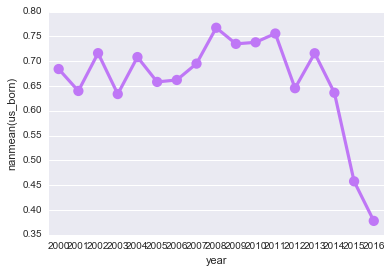

In [129]:
# Proportion US born by year
plt.figure()
sns.pointplot(x='year',y='us_born',data=with_ages, ci = 0, color=sns.xkcd_rgb["light purple"], estimator=np.nanmean)

Interestingly, this appears to have been stable over many years, at about 75% U.S. born, but in the last two years fell off a cliff. Does this affect changing readership? (perhaps the online edition is popular in more countries, so the Hot 100 has to reflect a global consensus?) Or changing sensibilities? (are American readers more aware of attractive celebrities from elsewhere in the world, perhaps thanks to social media?) Looking at the raw numbers, only 1 out of 2016's top 10 was born in America!

,name,mrank,us_born
1636,Stella Maxwell,1,0.0
1623,Irina Shayk,2,0.0
1594,Margot Robbie,3,0.0
1609,Barbara Palvin,4,0.0
1629,Alessandra Ambrosio,5,0.0
1689,Sasha Pivovarova,6,0.0
1685,Georgia May Jagger,7,0.0
1668,Ciara,8,1.0
1654,Devon Windsor,9,0.0
1651,Cara Delevingne,10,0.0


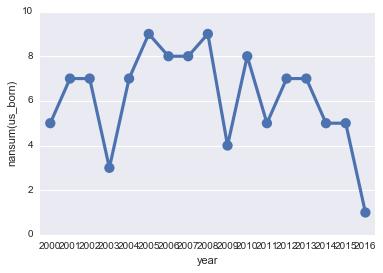

In [137]:
#%%
# Top 10 for the year number US born
plt.figure()
sns.pointplot(x='year',y='us_born',data=with_ages.loc[(with_ages.mrank<=10) ,:], ci=0, estimator=np.nansum)
with_ages.loc[(with_ages.mrank<=10) & (with_ages.year==2016),['name','mrank','us_born']].sort_values('mrank')

(incidentally I only recognize two of those names!)

Finally, I was curious about if more openly lesbian and bisexual women were on the list in recent years, due to changing sensibilities. I drew from Wikipedia category data, since a quick check indicated that most celebrities who are publicly gay are listed under "Lesbian actresses", "LGBT people from New Hampshire" etc. (one false positive I had to avoid: "LGBT activists") Just searching the text of the whole Wikipedia page for "lesbian" produced too many false positives, since many actresses had played lesbian roles.

The answer for people who identify exclusively as lesbian is exactly 1: Portia de Rossi, who made the Hot 100 in 2000 and 2004 (both before she came out of the closet in 2005). So the rest are people who have self-identified as bisexual (or are identified as such by others due to having had relationships with women). Because there's so few, it's easy to look at raw numbers (out of 100) for each year.

Overall percentage of people identifying as gay: 2.7%


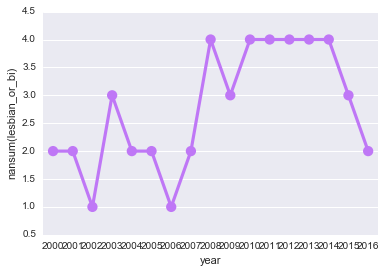

In [146]:
print "Overall percentage of people identifying as gay: %.1f%%"  % (100 * np.mean(with_ages.groupby('name').mean().lesbian_or_bi))
# Number lesbian or bi by year
plt.figure()
sns.pointplot(x='year',y='lesbian_or_bi',data=with_ages, ci = 0, color=sns.xkcd_rgb["light purple"], estimator=np.nansum)

There appears to be more LGBT Hot 100 entries in recent years, although 2016 had the fewest in 10 years.

As for transgender women on the Hot 100, did I even have to look? (I again used wikipedia categories, and the assumption that they would appear on lists such as "Transgender and transsexual actresses")

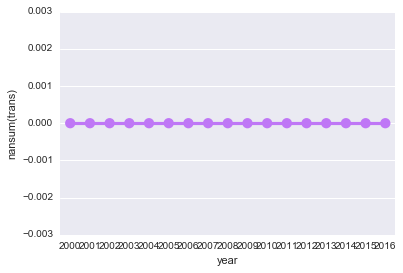

In [147]:
#%%
# Number trans by year
plt.figure()
sns.pointplot(x='year',y='trans',data=with_ages, ci = 0, color=sns.xkcd_rgb["light purple"], estimator=np.nansum)